<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/firstTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **First Approach**

After performing our [EDA](https://github.com/jjordana/twitter_sentiment_analysis/blob/master/EDA.ipynb), our next step is going to be to try to achieve some of the target data (_selected_text_).<br>
We will be using the previous output data.


## Importin Data, Libraries & More

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import random
import re, string
import collections

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet') # For the counterPlots
nltk.download('vader_lexicon') # For the counterPlots

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

We can check that we have all the data comming from the previous notebook. However, as we are not focus (well, not too much) on keep exploring our data, we are going to remove the columns corresponding to the `jaccScore`, `polarityScore` and `subjectivity`.


In [3]:
train = train.drop(columns=['Unnamed: 0', 'jaccScore', 'polarityScore', 'subjectivity'])
print(train['sentiment'].value_counts())
train.head()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


textID  ...                        newSelection
0  cb774db0d1  ...  i`d have responded if i were going
1  549e992a42  ...                              so sad
2  088c60f138  ...                         bullying me
3  9642c003ef  ...                      leave me alone
4  358bd9e861  ...                            sons of 

[5 rows x 6 columns]

We know that our dataset is a little bit `imbalanced`. This casuistics usually give us some difficulties when we try to solve it with the common algorightms. Tipical algorithms tend to focustowards the majority class, and the often do not considerate the data distribution. A good solution to deal this issue is to `oversample` or `undersample` each class. <br>
Nevertheless, as this is our first try, we are not going to change anything, just to see what happens.

In most of NLP processes, tokenization and lemmatization is a must. Therefore, let's go ahead with them. <br>
We are going to tokenize and lemmatize either the raw data (the one comming from the [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction)) and the traeted data _newText_ and _newSelection_ (result of cleaning all the not desired characters and applying a previous lemmatization).

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in str(text).lower().split(" ") if token != "" if token not in STOPWORDS]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [0]:
# Raw Data
train['textToken'] = train['text'].apply(tokenization)
train['selectedTextToken'] = train['selected_text'].apply(tokenization)
train['textToken'] = train['textToken'].apply(lemmatization)
train['selectedTextToken'] = train['selectedTextToken'].apply(lemmatization)

# Treated Data
train['newTextToken'] = train['newText'].apply(tokenization)
train['newSelectedTextToken'] = train['newSelection'].apply(tokenization)
train['newTextToken'] = train['newTextToken'].apply(lemmatization)
train['newSelectedTextToken'] = train['newSelectedTextToken'].apply(lemmatization)

How similar are our `selected_text` and `newSelecttion` tokens?<br>
Let's plot a simple graph to have an idea comparing their jaccard score.

In [0]:
def jaccardScore(a, b):  
  try:
    intersect = list(set(a).intersection(b)) # Common values between A and B
    union = len(a) + len(b) - len(intersect) # Values of A and B witout commons
    return round((len(intersect) / union), 2)
  except: # For those cases in which our tweet is mainly composed of STOPWORDS
    return 1

In [0]:
train['jaccScore'] = train.apply(lambda x: jaccardScore(x.selectedTextToken, x.newSelectedTextToken), axis=1)

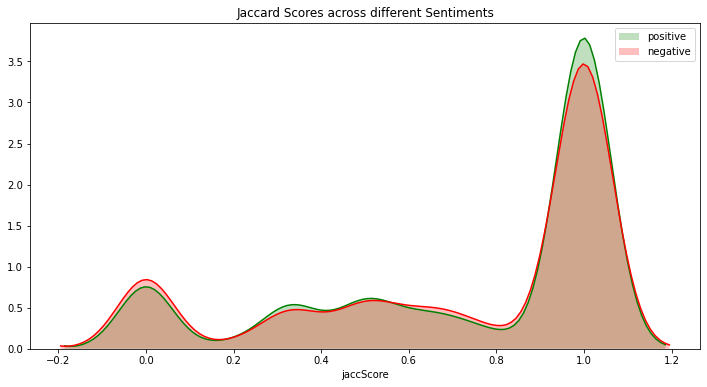

In [8]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)

plt.legend(labels=['positive','negative'])

Interesting.<br>
We can see that the jaccar score is well distributed, but in any case it behaves in the same way for positive and negative tweets. <br>
Besides, is seems that in the majority of the cases our `newSelection` and `selection_text` have a high similarity.

If we plot also neutral tweets, we can see that it's behavour is more arbitrary.

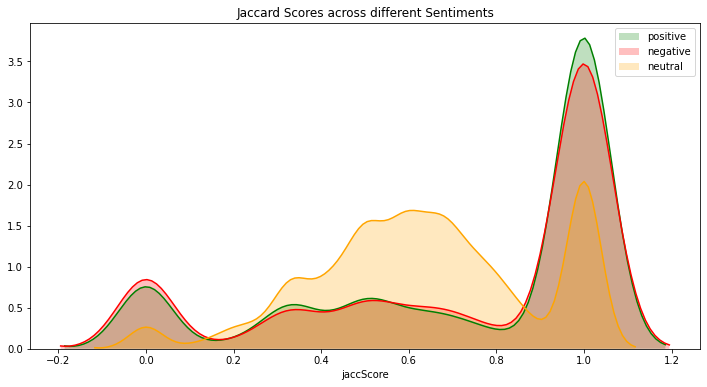

In [9]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)
p2=sns.distplot(train[train['sentiment']=='neutral']['jaccScore'], kde_kws={"shade": True}, color="orange", hist=False)


plt.legend(labels=['positive','negative', 'neutral'])

We are going to try to get all the selected_words just using our tokens. <br>
As we saw before, there is an interesting score value called `polarity_score`. It gives information about how positive, neutral or negative is a word. Besides, there is another metric `compound` which merges all the weights for the given word. 

By calculating our polarity score we might be able to achieve some kind of good result.<br>
Firstly, we will tokenize our raw text __maintaning the STOPWORDS__. This time we want to keep all the data.<br>
Secondly, we will divide our study in three main parts. The division will be performed by sentiment. As we have seen before, neutral sentiment tweets behave randomyl. Therefore we must analyze them separetly.

In [0]:
df = train[['text', 'selected_text', 'sentiment', 'newText', 'newSelection']]

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in str(text).lower().split(" ") if token != ""]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

# Function for getting the score of the whole tweet
def sentiment_analyzer_scores(tokens):
  scores = []
  for word in tokens:
    score = sid.polarity_scores(str(word))
    score = score['compound']
    scores.append(score)
  return scores

In [0]:
df['token'] = df['newText'].apply(tokenization)
df['tokenScore'] = df['token'].apply(sentiment_analyzer_scores)

For each token we want to calculate its polarity score. 
If the tweet is positive or negative, we will focus on those scores that have the highest value. That value would be key for determining from where do we start getting our first seelcted word.

However, how do we know how many words do we need to get? This is difficult to get.<br>
For the moment, we will try to plot if there is any realtion between the `selected_text` and the `text` lengths. 

### Positive

In [0]:
df1 = df[df.sentiment=='positive']

In [0]:
df1['tokenLen'] = df1['token'].apply(len)
df1['selectedToken'] = df1['selected_text'].apply(tokenization)
df1['selectedLen'] = df1['selectedToken'].apply(len)

df2 = df1.groupby(['tokenLen'])['tokenLen','selectedLen'].mean()

Text(0.5, 1.0, 'Tweet length V.S. selected_text mean')

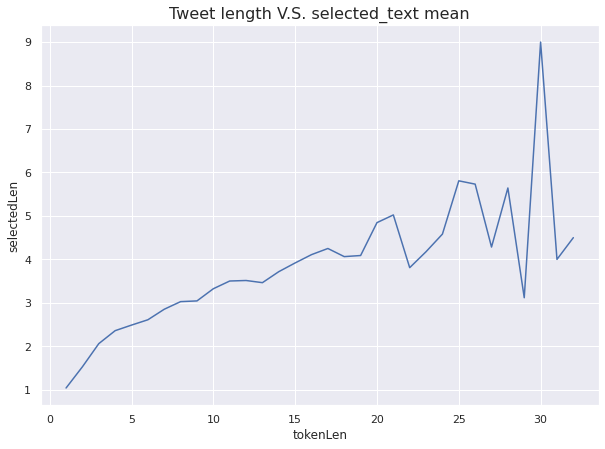

In [16]:
my_palette = sns.color_palette("muted")
sns.set(rc={'figure.figsize':(10, 7)})
sns.lineplot(x='tokenLen', y="selectedLen", data=df2, palette=my_palette) .set_title('Tweet length V.S. selected_text mean', fontsize=16)

For each different length of out tweets, we have calculated the mean value of the selected text. This is crucial to know how many words should we take. For example, tweets with 15 tokens have a mean of 4 words in their __selected_test__. This can be helptful in our selection.

In [0]:
def decider(tokensScore, sentiment, tokenLen, token, text):
  #tokenScore: polarity of each token from our tweet.
  #tokenLen: length of our token
  values = tokensScore
  # if sentiment == 'positive':
  #   values = [item for item in tokensScore if item >= 0]
  # print(text)
  try:
    maxVal = max(values)
  except:
    maxVal = values[0]
  indexMax = tokensScore.index(maxVal)
  
  #length of the selected_text that we must use
  meanWords = int(df2[df2.tokenLen==tokenLen]['selectedLen'])

  st = {}
  st[indexMax] = token[indexMax]

  index = indexMax
  count = 0
  for val in range(1, meanWords):
    if count % 2 == 0:
      index = index + val
    else: 
      index = index - val
    
    try:
      st[index] = token[index]
      count += 1
    except IndexError: # in case our index over pass
      position = len(token) - index
      if position <= 0: # end of array
        newIndex = len(token) - (val +1)
      elif position > 0: # begining of array
        newIndex = val
      st[newIndex] = token[newIndex]
  
  return list(collections.OrderedDict(sorted(st.items())).values())

In [0]:
df1['result'] = df1.apply(lambda x: decider(tokensScore=x.tokenScore, 
                                            sentiment='positive', 
                                            tokenLen=x.tokenLen, 
                                            token=x.token, text=x.text), axis=1)

In [0]:
pd.set_option('display.max_rows', None)


In [0]:
def checker(selectedToken, result):
  avg = 0
  for val in selectedToken:
    if val in result:
      avg = avg + 1
  avg = avg / len(selectedToken)
  return avg

In [55]:
df1['avg'] = df1.apply(lambda x: checker(selectedToken=x.selectedToken, result=x.result), axis=1)
df1

text  ...       avg
6      2am feedings for the baby are fun when he is a...  ...  1.000000
9       Journey!? Wow... u just became cooler.  hehe....  ...  0.200000
11     I really really like the song Love Story by Ta...  ...  0.000000
21     Playing Ghost Online is really interesting. Th...  ...  0.000000
25     the free fillin` app on my ipod is fun, im add...  ...  0.272727
...                                                  ...  ...       ...
27466  morning twit-friends! welcome to my new followers  ...  1.000000
27473  So I get up early and I feel good about the da...  ...  0.500000
27474                                     enjoy ur night  ...  1.000000
27477   Yay good for both of you. Enjoy the break - y...  ...  0.500000
27478                         But it was worth it  ****.  ...  0.500000

[8582 rows x 14 columns]

In [62]:
df1

text  ...       avg
6      2am feedings for the baby are fun when he is a...  ...  1.000000
9       Journey!? Wow... u just became cooler.  hehe....  ...  0.200000
11     I really really like the song Love Story by Ta...  ...  0.000000
21     Playing Ghost Online is really interesting. Th...  ...  0.000000
25     the free fillin` app on my ipod is fun, im add...  ...  0.272727
28     juss came backk from Berkeleyy ; omg its madd ...  ...  1.000000
30     I`m going home now. Have you seen my new twitt...  ...  0.000000
31     i hope unni will make the audition . fighting ...  ...  1.000000
33                        That`s very funny.  Cute kids.  ...  0.000000
39     A little happy for the wine jeje ok it`sm my f...  ...  0.000000
41     im an avid fan of **** magazine and i love you...  ...  0.000000
44      I love to! But I`m only available from 5pm.  ...  ...  0.666667
54                                 romance zero is funny  ...  0.500000
63     What better way to spoil mum than to let her k...  ...  1.000000
66       He`s awesome... Have you worked with him bef...  ...  0.500000
68                                              Chilliin  ...  1.000000
71      a celtics-lakers rematch sounds better don`t ...  ...  1.000000
80                       THANK YYYYYYYYYOOOOOOOOOOUUUUU!  ...  0.500000
81      lucky kid...i so wanna see loserville  pity i...  ...  1.000000
85     Happy Star Wars day everyone! and Enjoy the ho...  ...  0.200000
89      Well what im working on isn`t QUITE ready to ...  ...  0.000000
90      SWEEEEET - San Fran is awesome!!!!  Love it t...  ...  0.666667
95           Happy Mothers day to all you Mums out there  ...  0.333333
99        We saw that in none 3D - the baddie`s the best  ...  1.000000
100                     4am. And Im on the beach. Pretty  ...  1.000000
104     Awesome.  I`m down in Ocean Beach (if you kno...  ...  0.000000
107     haha I do not know how to work blip apart fro...  ...  0.000000
108     have a safe trip joshy poo.......you`ll knock...  ...  1.000000
109                     woof, I wish I was allowed to go  ...  0.428571
112    Thank you, Afrin Nasal Spray! Also, I got a gi...  ...  0.500000
114    Aww, I love my daddy! He works 7 days a week a...  ...  1.000000
117                                hahaa your awesomee !  ...  0.500000
118      holy smokes! star trek was freaking awesomeeeee  ...  0.000000
125                                       Not a prob hun  ...  0.666667
129     hey mia!  totally adore your music.  when wil...  ...  0.500000
130    Shopping. Cleaning. BMFing. Webcam chatting wi...  ...  1.000000
131     =O you need to ask him something? Lmao I love...  ...  0.750000
134     Nice to see you tweeting!  It`s Sunday 10th M...  ...  0.000000
135    decided 2 trans frm relaxed 2 natural hair but...  ...  0.000000
148                        Candle wax is very enjoyable.  ...  0.000000
149     She`s unassuming and unpretentious. She`s jus...  ...  0.000000
151    goooooddd morning tweets!!  week three OF my w...  ...  0.333333
153     fine! Going to do my big walk today 20 or so ...  ...  0.000000
159    _Laurie sending love, blessings & healing thou...  ...  0.181818
166      #lichfield #tweetup sounds like fun  Hope to...  ...  0.500000
168        Few Bevvies 2day in twn..great on a day off!!  ...  0.000000
169    first night in myers. just not the same w/out ...  ...  1.000000
170                                         good morning  ...  0.500000
171                              its the best show EVER!  ...  0.400000
181    who watched X-men origins: wolverine? i totall...  ...  0.500000
182     I VOTED!!! do u have a personal myspace? i ke...  ...  0.076923
190                                     happy 1 year! <3  ...  0.500000
191    Oh, I HELLA forgot to say my official good mor...  ...  0.000000
197             nite nite bday girl  have fun at concert  ...  0.500000
206          happy mother`s day to all moms out there...  ...  1.000000
208    im thinking t

In [47]:
a = [0.0, 0.296, 0.0]
c = ['are', 'fun', 'when']
maxVal = max(a)
indexMax = a.index(maxVal)
meanWords = 3
st = {}
st[indexMax] = c[indexMax]

index = indexMax
count = 0
for val in range(1, meanWords):
  if count % 2 == 0:
    index = index + val
  else: 
    index = index - val
  
  try:
    st[index] = c[index]
    count += 1
  except IndexError:
    position = len(a) - index
    if position <= 0: # end of array
      newIndex = len(a) - (val +1)
      st[newIndex] = c[newIndex]
    elif position > 0:
      newIndex = val
      st[newIndex] = c[newIndex]
print(st)

{1: 'fun', 2: 'when', 0: 'are'}


In [39]:
collections.OrderedDict(sorted(st.items())).values()

odict_values([0.0, 0.0, 0.8, -0.34])

In [50]:
words = list(collections.OrderedDict(sorted(st.items())).values())
token = [token for token in words if token not in STOPWORDS]
token

['fun']

In [0]:
df1[df1['tokenLen']==0]

In [0]:
tokensScore = [0.2023, 0.9182, 0.0, 0.001, 0.11, 0.4019, 0.932]
values = ""
if 'positive' == 'positive':
  values = [item for item in tokensScore if item >= 0]

maxVal = max(values)
maxVal

In [0]:
df[df['sentiment']!='neutral'][20:30]

In [0]:
for val in ['so', 'sad', 'i', 'will ', 'miss', 'you', 'here', 'in', 'san', 'diego']:
  print(val, ": ", sid.polarity_scores(str(val)))